In [1]:
!pip3 install hub==2.0.4 && torch==1.8.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 32.0 MB/s 
     |████████████████████████████████| 132 kB 51.2 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 3.0 MB 52.4 MB/s 
     |████████████████████████████████| 9.9 MB 41.0 MB/s 
     |████████████████████████████████| 79 kB 5.5 MB/s 
     |████████████████████████████████| 140 kB 54.1 MB/s 
     |████████████████████████████████| 47 kB 4.7 MB/s 
     |████████████████████████████████| 90 kB 10.8 MB/s 
     |████████████████████████████████| 66 kB 5.3 MB/s 
     |████████████████████████████████| 48 kB 5.6 MB/s 
     |████████████████████████████████| 64 kB 3.4 MB/s 
     |████████████████████████████████| 379 kB 72.5 MB/s 
     |████████████████████████████████| 92 kB 11.0 MB/s 
     |████████████████████████████████| 115 kB 

In [1]:
import numpy as np
import hub
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
from torchsummary import summary
import torchvision.models as models
import glob
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(hub.__version__)

2.0.4


In [3]:
print(torch.__version__)

1.12.1+cu113


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15502, done.
remote: Total 15502 (delta 0), reused 0 (delta 0), pack-reused 15502
Receiving objects: 100% (15502/15502), 14.17 MiB | 24.06 MiB/s, done.
Resolving deltas: 100% (10405/10405), done.


In [6]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [7]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [8]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [9]:
# get yolov3 weights
!wget https://pjreddie.com/media/files/yolov3.weights
!chmod a+x ./darknet

--2022-11-17 05:39:34--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  45.3MB/s    in 5.6s    

2022-11-17 05:39:40 (42.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [10]:
!unzip '/content/drive/MyDrive/CSULB Assignments/CECS 551 ADV AI/Assignment 8/img_align_celeba.zip'

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

In [11]:
!unzip '/content/drive/MyDrive/CSULB Assignments/CECS 551 ADV AI/Assignment 8/Selected_Dataset.zip'

Archive:  /content/drive/MyDrive/CSULB Assignments/CECS 551 ADV AI/Assignment 8/Selected_Dataset.zip
   creating: Selected_Dataset/1223/
  inflating: Selected_Dataset/1223/002249.jpg  
  inflating: Selected_Dataset/1223/006173.jpg  
  inflating: Selected_Dataset/1223/014229.jpg  
  inflating: Selected_Dataset/1223/018734.jpg  
  inflating: Selected_Dataset/1223/033044.jpg  
  inflating: Selected_Dataset/1223/037724.jpg  
  inflating: Selected_Dataset/1223/037973.jpg  
  inflating: Selected_Dataset/1223/043544.jpg  
  inflating: Selected_Dataset/1223/043645.jpg  
  inflating: Selected_Dataset/1223/049571.jpg  
  inflating: Selected_Dataset/1223/054110.jpg  
  inflating: Selected_Dataset/1223/063865.jpg  
  inflating: Selected_Dataset/1223/065244.jpg  
  inflating: Selected_Dataset/1223/065868.jpg  
  inflating: Selected_Dataset/1223/066850.jpg  
  inflating: Selected_Dataset/1223/084805.jpg  
  inflating: Selected_Dataset/1223/090599.jpg  
  inflating: Selected_Dataset/1223/096408.jpg  

In [12]:
!ls

3rdparty	DarknetConfig.cmake.in	include		       results
backup		darknet_images.py	json_mjpeg_streams.sh  scripts
build		darknet.py		LICENSE		       Selected_Dataset
build.ps1	darknet_video.py	Makefile	       src
cfg		data			net_cam_v3.sh	       vcpkg.json
cmake		image_yolov3.sh		net_cam_v4.sh	       video_yolov3.sh
CMakeLists.txt	image_yolov4.sh		obj		       video_yolov4.sh
darknet		img_align_celeba	README.md	       yolov3.weights


In [21]:
!git clone https://github.com/ultralytics/yolov3
!pip install -r yolov3/requirements.txt
!pip install facenet-pytorch

Cloning into 'yolov3'...
remote: Enumerating objects: 10058, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 10058 (delta 19), reused 28 (delta 13), pack-reused 10017
Receiving objects: 100% (10058/10058), 9.37 MiB | 22.89 MiB/s, done.
Resolving deltas: 100% (6778/6778), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 29.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 34.4 MB/s 


In [40]:
import glob
data_dir = '/content/darknet/Selected_Dataset'

list_imgs = glob.glob(data_dir + "/**/*.jpg")
print(f"There are {len(list_imgs)} images in the dataset {data_dir}")

There are 1200 images in the dataset /content/darknet/Selected_Dataset


In [41]:
# create dataloader with required transforms 
tc = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()              
    ])

In [42]:
image_datasets = datasets.ImageFolder(data_dir, transform=tc)
dloader = torch.utils.data.DataLoader(image_datasets, batch_size=10, shuffle=False)

In [43]:
print(len(image_datasets))

1200


torch.Size([256, 256, 3])
tensor([[[0.00000, 0.00000, 0.00000,  ..., 0.00392, 0.00392, 0.00392],
         [0.00000, 0.00000, 0.00000,  ..., 0.00392, 0.00392, 0.00392],
         [0.00000, 0.00000, 0.00000,  ..., 0.00392, 0.00392, 0.00392],
         ...,
         [0.00000, 0.00000, 0.00000,  ..., 0.23529, 0.18039, 0.15294],
         [0.00000, 0.00000, 0.00000,  ..., 0.28235, 0.22745, 0.18824],
         [0.00000, 0.00000, 0.00000,  ..., 0.28235, 0.22745, 0.18824]],

        [[0.00000, 0.00000, 0.00000,  ..., 0.00392, 0.00392, 0.00392],
         [0.00000, 0.00000, 0.00000,  ..., 0.00392, 0.00392, 0.00392],
         [0.00000, 0.00000, 0.00000,  ..., 0.00392, 0.00392, 0.00392],
         ...,
         [0.00000, 0.00000, 0.00000,  ..., 0.16078, 0.11373, 0.08627],
         [0.00000, 0.00000, 0.00000,  ..., 0.20392, 0.16078, 0.12157],
         [0.00000, 0.00000, 0.00000,  ..., 0.20784, 0.16078, 0.12157]],

        [[0.00000, 0.00000, 0.00000,  ..., 0.00392, 0.00392, 0.00392],
         [0.00000, 

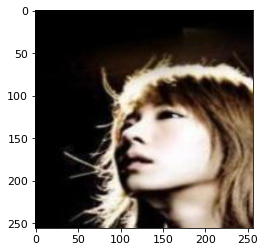

In [44]:
for img, label in dloader:
  print(np.transpose(img[0], (1,2,0)).shape)
  print(img[0])
  plt.imshow((img[0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
  plt.show()
  break

In [45]:
def copy_embeddings(m, i, o):
    """Copy embeddings from the penultimate layer.
    """
    o = o[:, :, 0, 0].detach().numpy().tolist()
    outputs.append(o)

In [46]:
# fetch pretrained model
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model = torch.hub.load('ultralytics/yolov3', 'yolov3')  # or yolov3-spp, yolov3-tiny, custom


Using cache found in /root/.cache/torch/hub/ultralytics_yolov3_master


In [ ]:
image_f = '/content/darknet/Selected_Dataset/1223/002249.jpg'

In [47]:
results = model("/content/darknet/Selected_Dataset/1223/002249.jpg")

In [48]:
results.print()

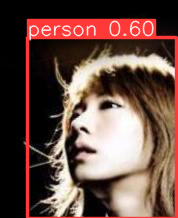

In [49]:
results.show()


In [50]:
crop_result = results.crop()


In [51]:
arr = crop_result[0]['im']
from PIL import Image
import numpy as np

arr = np.flip(arr, axis=-1)
PIL_image = Image.fromarray(np.uint8(arr)).convert('RGB')
PIL_image.save("crop_face_4.jpg")

In [52]:
arr.shape

(188, 157, 3)

In [53]:
from PIL import Image
im = Image.fromarray(arr).convert('RGB')
im.save("crop_face4-1.jpg")

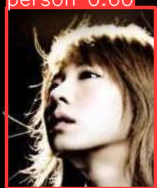

In [54]:
PIL_image.show()

In [55]:
results